In [5]:
from keras.layers import Dense, Input, Flatten, Lambda, Dropout
from keras.models import Model
from keras.applications import VGG19
from keras.optimizers import Adam, Adagrad
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


Using TensorFlow backend.


In [0]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from glob import glob


In [0]:
train_path = 'train'
test_path = 'test'

In [0]:
image_files = glob(train_path + '/*/*.jp*g')
test_files = glob(test_path + '/*/*.jp*g')


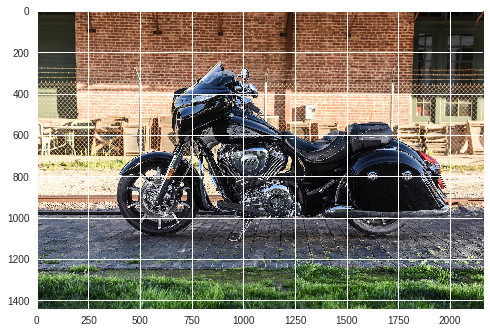

In [11]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [12]:
vgg = VGG19(include_top=False,input_shape=[224,224,3])

80142336/80134624 [==============================] - 2s 0us/step


In [0]:
for layer in vgg.layers:
    layer.trainable = False

In [0]:
x = Flatten()(vgg.output)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)
prediction = Dense(5,activation='softmax')(x)

In [0]:
model = Model(inputs=vgg.input, outputs=prediction)

In [16]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])


In [0]:
gen = ImageDataGenerator(rescale=1./255)

In [19]:
test_gen = gen.flow_from_directory(test_path, target_size=(224,224))
print(test_gen.class_indices)
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Found 212 images belonging to 5 classes.
{'Bike': 0, 'Car': 1, 'Cat': 2, 'Dog': 3, 'Human': 4}


min: 0.0 max 1.0


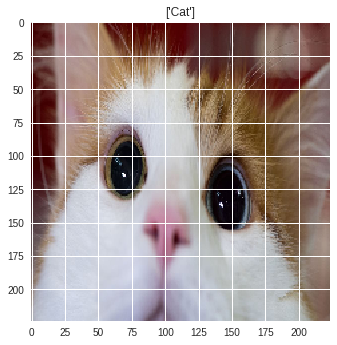

In [21]:
for x,y in test_gen:
    print("min:",x[0].min(),"max",x[0].max())
    plt.title([labels[np.argmax(y[0])]])
    plt.imshow(x[0])
    plt.show()
    break

In [22]:
train_gen = gen.flow_from_directory(train_path, target_size=(224,224))


Found 740 images belonging to 5 classes.


In [23]:
r = model.fit_generator(train_gen,validation_data=test_gen,
                        epochs=15, steps_per_epoch=len(image_files)//batch_size,
                        validation_steps=len(test_files)//batch_size)


Epoch 1/15
23/23 [==============================] - 264s 11s/step - loss: 1.4876 - acc: 0.4718 - val_loss: 0.6443 - val_acc: 0.8125
Epoch 2/15
23/23 [==============================] - 35s 2s/step - loss: 0.6196 - acc: 0.7269 - val_loss: 0.4166 - val_acc: 0.8438
Epoch 3/15
23/23 [==============================] - 35s 2s/step - loss: 0.5080 - acc: 0.7654 - val_loss: 0.3908 - val_acc: 0.8542
Epoch 4/15
23/23 [==============================] - 35s 2s/step - loss: 0.4081 - acc: 0.8288 - val_loss: 0.2482 - val_acc: 0.9062
Epoch 5/15
23/23 [==============================] - 35s 2s/step - loss: 0.3505 - acc: 0.8682 - val_loss: 0.2864 - val_acc: 0.8854
Epoch 6/15
23/23 [==============================] - 33s 1s/step - loss: 0.2635 - acc: 0.9034 - val_loss: 0.2423 - val_acc: 0.8906
Epoch 7/15
23/23 [==============================] - 33s 1s/step - loss: 0.2501 - acc: 0.9170 - val_loss: 0.2136 - val_acc: 0.9427
Epoch 8/15
23/23 [==============================] - 33s 1s/step - loss: 0.2349 - acc: 0.

In [24]:
model.evaluate_generator(test_gen)

[0.23329420134706316, 0.9150943418718734]

In [25]:
model.evaluate_generator(train_gen)

[0.006526575382874423, 1.0]

In [0]:
model.save('vgg19_model.h5')

In [0]:
def get_confusion_matrix(data_path, N):
    print('generating confusion_matrix')
    predictions = []
    targets = []
    for x,y in gen.flow_from_directory(data_path, target_size=(224,224),shuffle=False):
        p = model.predict(x)
        p = np.argmax(p, axis = 1)
        y = np.argmax(y, axis = 1)
        predictions = np.concatenate((predictions,p))
        targets = np.concatenate((targets, y))
        if len(targets)>=N:
            break
    cm = confusion_matrix(targets, predictions)
    return cm

In [28]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

generating confusion_matrix
Found 740 images belonging to 5 classes.
[[116   0   0   0   0]
 [  0 108   0   0   0]
 [  0   0 132   0   0]
 [  0   0   0 144   0]
 [  0   0   0   0 240]]


In [29]:
valid_cm = get_confusion_matrix(test_path, len(test_files))
print(valid_cm)


generating confusion_matrix
Found 212 images belonging to 5 classes.
[[45  0  1  0  0]
 [ 1 37  0  0  0]
 [ 0  0 30  5  2]
 [ 0  0  6 28  3]
 [ 0  0  0  0 54]]


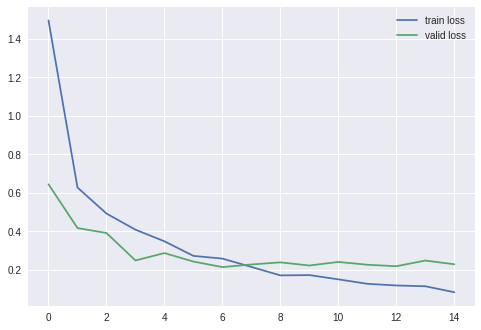

In [30]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'valid loss')
plt.legend()
plt.show()

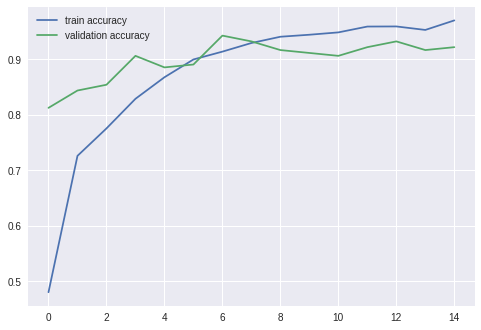

In [31]:
plt.plot(r.history['acc'], label = 'train accuracy')
plt.plot(r.history['val_acc'], label ='validation accuracy')
plt.legend()
plt.show()